# Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import optuna

# Import ML models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Load file

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [3]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


# Define feature and target columns

In [6]:
# Define feature columns and target
X = train.drop(columns=['id', 'loan_status'])
y = train['loan_status']
X_test = test.drop(columns=['id'])

# Train test split

In [7]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature Engineering

In [8]:
# Custom function to create new features
def feature_engineering(df):
    # Log transformation
    df['log_person_income'] = np.log1p(df['person_income'])
    df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
    
    # Debt-to-Income ratio
    df['dti_ratio'] = df['loan_amnt'] / df['person_income']
    
    # Employment categories
    df['employment_category'] = pd.cut(df['person_emp_length'], 
                                        bins=[-1, 2, 5, 10, 20], 
                                        labels=['Short-term', 'Medium-term', 'Long-term', 'Very long-term'])
    
    # Credit history and default indicator
    df['short_credit_history'] = (df['cb_person_cred_hist_length'] < 5).astype(int)
    df['default_history'] = (df['cb_person_default_on_file'] == 'Y').astype(int)
    
    # Risk indicators
    df['high_interest'] = (df['loan_int_rate'] > 12).astype(int)
    df['high_loan_percent_income'] = (df['loan_percent_income'] > 0.3).astype(int)
    
    return df

In [9]:
# Define custom transformer for feature engineering
feature_engineer = FunctionTransformer(feature_engineering)

In [10]:
# Updated numerical and categorical columns
numerical_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length',
                  'log_person_income', 'log_loan_amnt', 'dti_ratio']
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'employment_category']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Models and Hyperparameter tuning

In [11]:
# Initialize leaderboard to store the top 5 models for each type
leaderboard = {
    'xgboost': [],
    'catboost': [],
    'lgbm': []
}

In [14]:
def objective(trial):
    # Define the model type to test
    model_type = trial.suggest_categorical('model_type', [
#         'xgboost', 
#         'catboost', 
        'lgbm'])
    
    # Hyperparameter definitions for each model type
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 12),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
        }
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    elif model_type == 'catboost':
        params = {
            'iterations': trial.suggest_int('cat_iterations', 100, 2000),
            'depth': trial.suggest_int('cat_depth', 3, 12),
            'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.3),
            'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 1.0, 15.0)
        }
        model = CatBoostClassifier(**params, verbose=0, random_state=42)
    
    elif model_type == 'lgbm':
        params = {
                    'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 2000),
                    'num_leaves': trial.suggest_int('lgb_num_leaves', 31, 256),
                    'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
                    'min_child_samples': trial.suggest_int('lgb_min_child_samples', 10, 100),
                    # Additional parameters for fine-tuning
                    'max_depth': trial.suggest_int('lgb_max_depth', -1, 20),  # Maximum depth of the tree; -1 means no limit
                    'min_split_gain': trial.suggest_float('lgb_min_split_gain', 0.0, 5.0),  # Minimum gain required for a split
                    'reg_alpha': trial.suggest_float('lgb_reg_alpha', 0.0, 10.0),  # L1 regularization term
                    'reg_lambda': trial.suggest_float('lgb_reg_lambda', 0.0, 10.0),  # L2 regularization term
                    'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.6, 1.0),  # Subsample ratio of columns when constructing each tree
                    'subsample': trial.suggest_float('lgb_subsample', 0.6, 1.0),  # Subsample ratio of training instances
                    'subsample_freq': trial.suggest_int('lgb_subsample_freq', 1, 10),  # Frequency of subsample
                    'min_child_weight': trial.suggest_float('lgb_min_child_weight', 1e-3, 10.0),  # Minimum sum of instance weight (hessian) needed in a child
                    'max_bin': trial.suggest_int('lgb_max_bin', 100, 500),  # Maximum number of bins used for discretizing continuous features
                }
        model = LGBMClassifier(**params, verbosity=-1, random_state=42)
    
    # Final pipeline
    pipeline = Pipeline(steps=[
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train and evaluate the model
    pipeline.fit(X_train, y_train)
    val_preds = pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    
    # Update leaderboard for the model type
    leaderboard[model_type].append((auc, model))
    leaderboard[model_type] = sorted(leaderboard[model_type], key=lambda x: x[0], reverse=True)[:10]  # Keep top 10
    
    return auc

In [15]:
# Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Increase trials for better results

[I 2024-10-27 06:31:26,932] A new study created in memory with name: no-name-4ddaebad-8671-4cf8-99e6-97c2982659ec
[I 2024-10-27 06:31:32,300] Trial 0 finished with value: 0.95222260519224 and parameters: {'model_type': 'lgbm', 'lgb_n_estimators': 1024, 'lgb_num_leaves': 198, 'lgb_learning_rate': 0.23678608953623861, 'lgb_min_child_samples': 68, 'lgb_max_depth': 9, 'lgb_min_split_gain': 1.4081371066246595, 'lgb_reg_alpha': 7.0286264574598665, 'lgb_reg_lambda': 4.752028612286353, 'lgb_colsample_bytree': 0.8042371341314393, 'lgb_subsample': 0.9707823820701003, 'lgb_subsample_freq': 1, 'lgb_min_child_weight': 9.91438209717654, 'lgb_max_bin': 160}. Best is trial 0 with value: 0.95222260519224.
[I 2024-10-27 06:31:36,085] Trial 1 finished with value: 0.944396979973843 and parameters: {'model_type': 'lgbm', 'lgb_n_estimators': 1277, 'lgb_num_leaves': 177, 'lgb_learning_rate': 0.22728090829187375, 'lgb_min_child_samples': 47, 'lgb_max_depth': 12, 'lgb_min_split_gain': 3.369905070259481, 'lgb_r

In [18]:
# Collect top models from the leaderboard
top_models = []
for model_type, models in leaderboard.items():
    for auc, model in models:
        top_models.append({'Model Type': model_type, 'AUC-ROC': auc, 'Model': model})

# Sort the top models by AUC-ROC and select the best 10
top_models = sorted(top_models, key=lambda x: x['AUC-ROC'], reverse=True)[:10]

# Create a DataFrame to display the top models
top_models_df = pd.DataFrame(top_models)


In [19]:
top_models_df

,Model Type,AUC-ROC,Model
0,lgbm,0.959960,LGBMClassifier(colsample_bytree=0.756608515940...
1,lgbm,0.959933,LGBMClassifier(colsample_bytree=0.629998398077...
2,lgbm,0.959866,LGBMClassifier(colsample_bytree=0.628076420924...
3,lgbm,0.959688,LGBMClassifier(colsample_bytree=0.657629724182...
4,lgbm,0.959653,LGBMClassifier(colsample_bytree=0.624692972266...


# Ensemble score

In [20]:
# Wrap each model in a pipeline with preprocessing
ensemble_estimators = [
    (f'model_{i}', Pipeline(steps=[
        ('feature_engineering', feature_engineer),
        ('preprocessor', preprocessor),
        ('classifier', model['Model'])
    ]))
    for i, model in enumerate(top_models)
]

# Create the VotingClassifier ensemble with the preprocessed pipelines
ensemble = VotingClassifier(estimators=ensemble_estimators, voting='soft')

# Train the final ensemble on the full training data
ensemble.fit(X_train, y_train)

# Evaluate the ensemble on the validation set
ensemble_val_preds = ensemble.predict_proba(X_val)[:, 1]
ensemble_auc = roc_auc_score(y_val, ensemble_val_preds)

print(f"Ensemble AUC-ROC: {ensemble_auc}")

Ensemble AUC-ROC: 0.9604902333716105


# Ensemble on full original train set

In [21]:
# Train the final ensemble on the full training data
ensemble.fit(X, y)

VotingClassifier(estimators=[('model_0',
                              Pipeline(steps=[('feature_engineering',
                                               FunctionTransformer(func=<function feature_engineering at 0x781ddc643370>)),
                                              ('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['person_age',
                                                                                 'person_income',
                                                                                 'loan_amnt',
                                                                                 'loan_int_rate',
                                                                                 'cb_person_cred_hist_length',
                                                                                 'log_person_income',
                                                                                 'log_loan_amnt',
                                                                                 'dt...
                                               LGBMClassifier(colsample_bytree=0.6246929722668983,
                                                              learning_rate=0.05352158413099867,
                                                              max_bin=500,
                                                              max_depth=11,
                                                              min_child_samples=92,
                                                              min_child_weight=5.517244231879755,
                                                              min_split_gain=0.4069878453057915,
                                                              n_estimators=1918,
                                                              num_leaves=78,
                                                              random_state=42,
                                                              reg_alpha=0.7403960691757727,
                                                              reg_lambda=1.494331598848101,
                                                              subsample=0.9412810965409104,
                                                              subsample_freq=1,
                                                              verbosity=-1))]))],
                 voting='soft')

In [22]:
# Predict on the test set
test_preds = ensemble.predict_proba(test)[:, 1]

# Submission

In [23]:
# Prepare submission file
submission['loan_status'] = test_preds

In [24]:
submission.head()

,id,loan_status
0,58645,0.991522
1,58646,0.010120
2,58647,0.693790
3,58648,0.007512
4,58649,0.065025


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


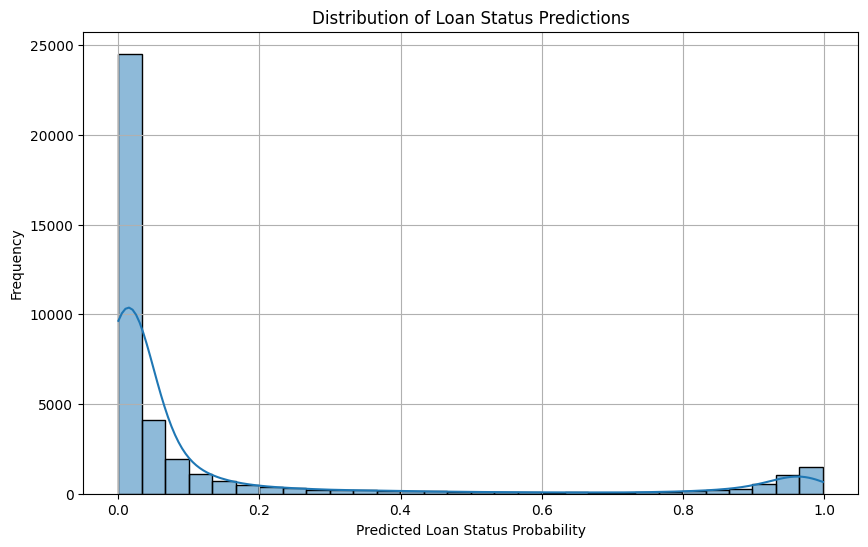

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the predictions
plt.figure(figsize=(10, 6))
sns.histplot(submission['loan_status'], bins=30, kde=True)
plt.title('Distribution of Loan Status Predictions')
plt.xlabel('Predicted Loan Status Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [26]:
submission.to_csv('submission.csv', index=False)